# Expression activity

This notebook examines the average expression activity of genes in order to:
1. Verify that accessory genes (i.e. PAO1 genes) mostly 0
2. Look at the data to determine if there are additional considerations to be made for our downstream analysis

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import fill

from core_acc_modules import paths_corr, utils

/home/alexandra/anaconda3/envs/core_acc_local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Load gene expression data
expression_df = pd.read_csv(paths_corr.PAO1_GE, sep="\t", index_col=0, header=0)

In [3]:
# Load metadata
pao1_metadata = pd.read_csv(paths_corr.PAO1_METADATA, index_col=0, header=0)
pa14_metadata = pd.read_csv(paths_corr.PA14_METADATA, index_col=0, header=0)

## Format gene ids

In [4]:
# Replace sequencing gene ids with PA ids
pao1_fasta_file = paths_corr.PAO1_REF
seq_id_to_gene_id_pao1 = utils.dict_gene_num_to_ids(pao1_fasta_file)
expression_df.rename(mapper=seq_id_to_gene_id_pao1, axis="columns", inplace=True)

expression_df.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
SRR2007333,16.748607,14.158337,21.634927,13.909423,1.788972,11.595190,0.357876,3.351434,20.005435,5.510585,...,72.733456,18.647072,14.590614,13.044588,14.853692,0.386506,1.771919,20.724064,58.741668,2586.632135
SRR8782928,69.982152,97.099262,87.449079,92.622825,13.779231,16.745594,4.421613,29.401579,68.994721,16.728675,...,323.603134,78.706919,183.358555,59.153266,50.738176,4.374359,42.394929,206.900132,818.025789,17618.048842
SRR8782932,43.671292,108.945058,31.600408,82.412376,9.481706,11.838603,4.957598,14.083611,30.924667,6.076368,...,50.626168,32.018869,71.347316,24.624295,16.342457,0.505114,9.933001,58.245928,397.133760,13079.049466
SRR12820672,30.021631,52.560065,26.536402,22.785072,18.115482,33.277848,2.962978,3.960106,8.609682,11.000073,...,137.505075,25.786259,24.032927,12.251220,26.211311,13.853613,7.087961,28.110579,552.090025,16939.944456
SRR12820655,56.445619,95.522156,27.881456,51.173257,21.218700,22.894728,7.746194,11.421012,14.734453,12.572734,...,133.140124,68.884391,26.866753,26.074096,28.517417,13.796927,9.017056,36.933886,576.759379,5803.250581


## Get core and accessory genes

In [5]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = paths_corr.GENE_PAO1_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pao1")
gene_mapping_pao1.head()

,Name,Product.Name,GeneID.(PAO1),PA14_ID,annotation,num_mapped_genes
PAO1_ID,,,,,,
PA0001,dnaA,chromosomal replication initiator protein DnaA,878417.0,PA14_00010,core,1.0
PA0002,dnaN,"DNA polymerase III, beta chain",879244.0,PA14_00020,core,1.0
PA0003,recF,RecF protein,879229.0,PA14_00030,core,1.0
PA0004,gyrB,DNA gyrase subunit B,879230.0,PA14_00050,core,1.0
PA0005,lptA,"lysophosphatidic acid acyltransferase, LptA",877576.0,PA14_00060,core,1.0


In [6]:
# Get mapping between PAO1 and PA14 genes using PA14 reference
gene_annot_file = paths_corr.GENE_PA14_ANNOT
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(gene_annot_file, "pa14")
gene_mapping_pa14.head()

,Name,Product.Name,GeneID.(PAO1),PAO1_ID,annotation,num_mapped_genes
PA14_ID,,,,,,
PA14_00010,dnaA,chromosomal replication initiation protein,878417.0,PA0001,core,1.0
PA14_00020,dnaN,DNA polymerase III subunit beta,879244.0,PA0002,core,1.0
PA14_00030,recF,recombination protein F,879229.0,PA0003,core,1.0
PA14_00050,gyrB,DNA gyrase subunit B,879230.0,PA0004,core,1.0
PA14_00060,NaN,acyltransferase,877576.0,PA0005,core,1.0


In [7]:
# Get core genes: genes that have a homolog between PAO1 and PA14
core_pao1_genes, core_pa14_genes = utils.get_core_genes(
    gene_mapping_pao1, gene_mapping_pa14, False
)
print(f"Number of PAO1 core genes: {len(core_pao1_genes)}")

Number of PAO1 core genes: 5366


In [8]:
# Select only core genes that are included in my dataset
pao1_ref_genes = expression_df.columns
my_core_pao1_genes = list(set(core_pao1_genes).intersection(pao1_ref_genes))

print(f"Number of PAO1 core genes in my dataset: {len(my_core_pao1_genes)}")

Number of PAO1 core genes in my dataset: 5363


In [9]:
# Get PAO1-specific genes
pao1_acc = list(set(pao1_ref_genes) - set(my_core_pao1_genes))
print(f"Number of PAO1-specific genes: {len(pao1_acc)}")

Number of PAO1-specific genes: 322


In [10]:
assert len(expression_df.columns) == len(my_core_pao1_genes) + len(pao1_acc)

In [11]:
# Check that `get_pao1_pa14_gene_map` function is working as expected
assert "PA0053" not in core_pao1_genes and "PA0053" in pao1_acc

## Get sample groups

In [12]:
# Get PAO1 and PA14 sample ids
pao1_ids = list(pao1_metadata.index)
pa14_ids = list(pa14_metadata.index)

## Plot expression activity

In [13]:
# Look at the expression of core genes in PAO1 and PA14 samples
expression_core_pao1 = expression_df.loc[pao1_ids, my_core_pao1_genes]
expression_core_pa14 = expression_df.loc[pa14_ids, my_core_pao1_genes]

expression_core_pao1_mean = expression_core_pao1.mean()
expression_core_pa14_mean = expression_core_pa14.mean()

/home/alexandra/anaconda3/envs/core_acc_local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Count')

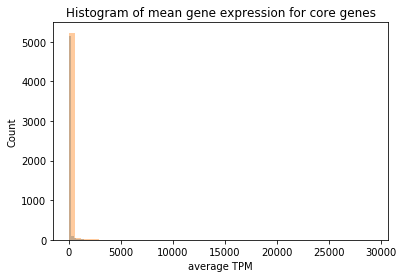

In [14]:
g = sns.distplot(expression_core_pao1_mean.values, kde=False)
g = sns.distplot(expression_core_pa14_mean.values, kde=False)
g.set_title("Histogram of mean gene expression for core genes")
g.set_xlabel("average TPM")
g.set_ylabel("Count")

In [15]:
# Look at the expression of core genes in PAO1 and PA14 samples
expression_acc_pao1 = expression_df.loc[pao1_ids, pao1_acc]
expression_acc_pa14 = expression_df.loc[pa14_ids, pao1_acc]

expression_acc_pao1_mean = expression_acc_pao1.mean()
expression_acc_pa14_mean = expression_acc_pa14.mean()

In [16]:
print(sum(expression_core_pao1_mean == 0))
print(sum(expression_acc_pao1_mean == 0))
print(sum(expression_core_pa14_mean == 0))
print(sum(expression_acc_pa14_mean == 0))

0
2
2
54


Text(0, 0.5, 'Count')

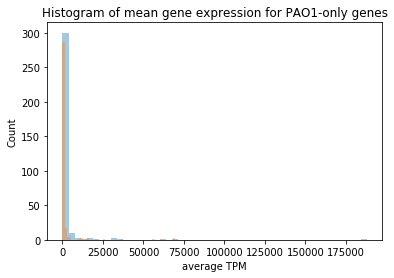

In [17]:
f = sns.distplot(expression_acc_pao1_mean.values, kde=False)
f = sns.distplot(expression_acc_pa14_mean.values, kde=False)
f.set_title("Histogram of mean gene expression for PAO1-only genes")
f.set_xlabel("average TPM")
f.set_ylabel("Count")

* Overall most genes have a TPM < 5000 and there is a very long tail in the distribution which is expected
* Looks like there is a slight shift in PA14 samples have lower expression of PAO1-only genes, as expected. There is still nonzero expression for many PAO1-only genes in PA14 samples. How should we deal with this?
  * Should we use presence/absence information to exclude certain samples from our correlation on a per-gene basis? This will be difficult because we will need to get this information somehow
  * Should we only consider samples within PAO1 for these PAO1-only genes?
* Looks like there is higher expression in core genes for both PAO1 and PA14 samples, as expected
* There is a difference in the overall expression level of core vs PAO1-only genes. Since we plan to use Spearman correlation which is based on the ordering of values, I don't think the raw activity should effect the correlation.